# Imports and data processing

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 9.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=043cb7ea60deedaf48282b34e4b81044f61eb8edbd2d54c07da15085aa556467
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
import random
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import random as rd

import copy

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


In [ ]:
# !unzip "_data.zip"

In [ ]:

def get_samples(style="J", train=True, n=100, random=False):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    train : bool, optional
        Whether to choose the train or validation set, by default True
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """

    folder = ""
    prefix = "jazz"
    if style == "J":
        folder = "JC_J"
        prefix = "jazz"
    elif style == "C":
        folder = "JC_C"
        prefix = "classic"
    else:
        raise Exception("'style' must be one of {'J', 'C'}")
    
    
    train_or_valid = "train" if train else "test"

    nb_samples = 4000
    numbers = list(range(1, nb_samples))
    if random:
        np.random.shuffle(numbers)
    numbers = numbers[:n]

    samples = []
    for number in numbers:
        filepath = f"{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"
        if os.path.isfile(filepath):
            sample = np.load(filepath)
            # samples.append(sample.astype(int).reshape((64 * 84, 1)))
            samples.append(sample.astype(int).reshape((1, 64 * 84)))

    # return np.column_stack(samples)
    return np.vstack(samples)

# Get sample V2

In [ ]:
def get_samplesV2(style="C", length=64, n=3000, random=False):
   
    folder = ""
    if style == "J":
      folder = "content/jazzData"
    
    elif style == "C":
      folder = "content/classicalData"

    else:
      raise Exception("'style' must be one of {'J', 'C'}")
    
    list_filenames = os.listdir(folder)
    nb_samples_per_file = max(int(n/len(list_filenames)), 1)

    samples = []
    for filename in list_filenames:
      if filename[-3:] =="npy":
         
          
        filepath = folder + "/" + filename
        

        all_file = np.load(filepath).astype(int)
        all_file_size = len(all_file)

        for k in range(nb_samples_per_file):
          first_index = rd.randint(0, all_file_size-length-1)
          sample = all_file[first_index:first_index+length]
          samples.append(sample.reshape((1, 64 * 84)))
          
    return np.vstack(samples)

In [ ]:
test = get_samplesV2()

## Model creation

In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, batch_size))
    return n

In [ ]:
latent_dim = 100


class CNNGenerator(nn.Module):
    def __init__(self, deepth):
        super(CNNGenerator, self).__init__()
        n_features = latent_dim
        n_out = 64 * 84
   
        # Latent vector going into a convolution
        self.convt1 =  nn.ConvTranspose2d(latent_dim, deepth*8, 4, 1, 0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(deepth*8)

        # state size : (deepth*8, 4, 4)
        self.convt2 = nn.ConvTranspose2d(deepth*8, deepth*4, 4, 2, 1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(deepth*4)

        #state size : (deepth*4, 8, 8)
        self.convt3 = nn.ConvTranspose2d(deepth*4, deepth*2, (4,2),(2,3), 1,bias=False)
        self.batchnorm3 = nn.BatchNorm2d(deepth*2)

        #state size : (deepth*2, 16, 21)
        self.convt4 = nn.ConvTranspose2d(deepth*2, deepth, 4,2, 1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(deepth)

        #state size : (deepth, 32, 42)
        self.convt5 = nn.ConvTranspose2d(deepth,1, 4,2, 1,bias=False)

    def forward(self, x):
        x = self.convt1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.convt2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.convt3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.convt4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = self.convt5(x)
        x = F.sigmoid(x)
        x = x.view(x.size()[0],64,84)
        return x

In [ ]:
# import torch.nn.init as init
# class MinibatchDiscrimination(nn.Module):
#     def __init__(self, in_features, out_features, kernel_dims, mean=False):
#         super().__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.kernel_dims = kernel_dims
#         self.mean = mean
#         self.T = nn.Parameter(torch.Tensor(in_features, out_features, kernel_dims))
#         init.normal(self.T, 0, 1)

#     def forward(self, x):
#         # x is NxA
#         # T is AxBxC
#         matrices = x.mm(self.T.view(self.in_features, -1))
#         matrices = matrices.view(-1, self.out_features, self.kernel_dims)

#         M = matrices.unsqueeze(0)  # 1xNxBxC
#         M_T = M.permute(1, 0, 2, 3)  # Nx1xBxC
#         norm = torch.abs(M - M_T).sum(3)  # NxNxB
#         expnorm = torch.exp(-norm)
#         o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance
#         if self.mean:
#             o_b /= x.size(0) - 1

#         x = torch.cat([x, o_b], 1)
#         return x

In [ ]:



class CNNDiscriminator(nn.Module):
    def __init__(self, num_conv1, kernel_size1, num_conv2, kernel_size2, num_fc):
        super(CNNDiscriminator, self).__init__()
        n_features = 64 * 84
        n_out = 1

        self.conv_1 = nn.Conv2d(in_channels=1,out_channels=num_conv1,kernel_size=kernel_size1)
        self.drop1 = nn.Dropout(0.3)
        self.conv_2 = nn.Conv2d(num_conv1,num_conv2,kernel_size1)
        self.drop2 = nn.Dropout(0.3)
        self.fc_1 = nn.Linear(1680, num_fc)
        # self.mbd1 = MinibatchDiscrimination(num_fc, num_fc, 50)
        self.fc_2 = nn.Linear(num_fc, n_out)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.drop1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv_2(x)
        x = self.drop2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = F.relu(self.fc_1(x))
        x = F.sigmoid(self.fc_2(x))
        return x

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [ ]:
def get_dist_matrix(numpy_array_data):
  dist = 0
  counter = 0
  for i in range(len(numpy_array_data)):
    matrix_i = numpy_array_data[i]
    for j in range(i+1, len(numpy_array_data)):
      matrix_j = numpy_array_data[j]
      counter+=1

      dist += np.abs(matrix_i-matrix_j).sum()
  
  return dist/counter


# Training


In [1]:
n = 2000
batch_size = 16
data = get_samplesV2(style="C", n=n, random=True)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

In [ ]:
n_epochs = 200

G = CNNGenerator(64).to(device)

num_conv1 = 10
num_conv2 = 20
kernel_size1 = 12
kernel_size2 = 12
num_fc = 16*84
D = CNNDiscriminator(num_conv1, kernel_size1, num_conv2, kernel_size2, num_fc).to(device)

loss = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.5)
g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
nb_landmark_seeds = 10

landmark_seeds = Variable(torch.FloatTensor(torch.randn(nb_landmark_seeds, latent_dim))).view(nb_landmark_seeds,latent_dim, 1,1 )


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: D (0.3918 real_err, 0.4470 fake_err) G (1.0682 err) 
Generated data: 
Min value: 3.5205786844016984e-05 / Max value: 0.9999470710754395
Note played simultaneously for generated data  mean/var: 5.81 / 0.35


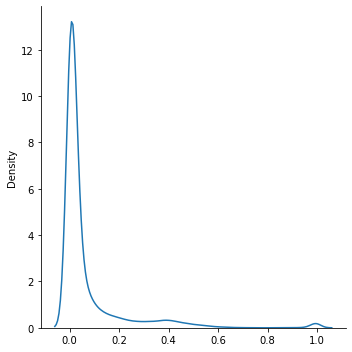

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 126.65729031032986
Epoch 10: D (0.4287 real_err, 0.2066 fake_err) G (1.9508 err) 
Generated data: 
Min value: 1.685352903205962e-33 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 3.02 / 0.63
Epoch 20: D (0.2987 real_err, 0.4041 fake_err) G (2.6522 err) 
Generated data: 
Min value: 1.9876735198481458e-32 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.33 / 1.39
Epoch 30: D (0.4780 real_err, 0.2031 fake_err) G (2.6700 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.38 / 1.57
Epoch 40: D (0.5400 real_err, 0.0652 fake_err) G (2.4003 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.05 / 1.10
Epoch 50: D (0.3540 real_err, 0.1054 fake_err) G (2.1120 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.31 / 0.67


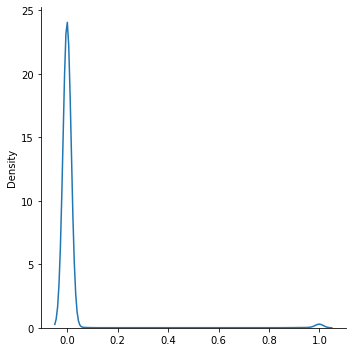

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 121.31983825365703
Epoch 60: D (0.6592 real_err, 0.0483 fake_err) G (1.5263 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.90 / 0.96
Epoch 70: D (0.0003 real_err, 0.0299 fake_err) G (3.1301 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.66 / 1.22
Epoch 80: D (1.5238 real_err, 0.0516 fake_err) G (1.6611 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.44 / 0.21
Epoch 90: D (0.0007 real_err, 0.0657 fake_err) G (4.4773 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.45 / 3.15
Epoch 100: D (0.0005 real_err, 0.1340 fake_err) G (4.0283 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.71 / 1.52


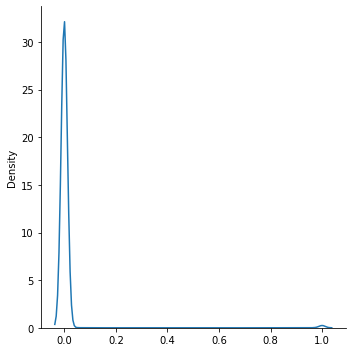

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 112.2082152971377
Epoch 110: D (0.1569 real_err, 0.0301 fake_err) G (3.5804 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.01 / 0.44
Epoch 120: D (0.0001 real_err, 0.2480 fake_err) G (4.8700 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.86 / 0.34
Epoch 130: D (0.3316 real_err, 0.9820 fake_err) G (4.8859 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.82 / 0.66
Epoch 140: D (0.2072 real_err, 0.0592 fake_err) G (4.3429 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.75 / 1.46
Epoch 150: D (0.0000 real_err, 0.2254 fake_err) G (4.3901 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.80 / 1.58


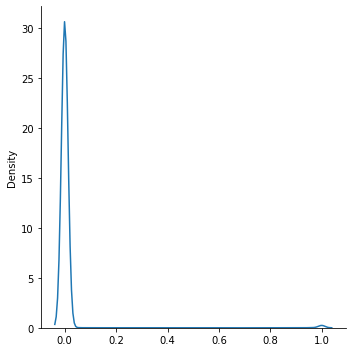

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 89.68194492847866
Epoch 160: D (0.0001 real_err, 0.0344 fake_err) G (3.5673 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.10 / 0.00
Epoch 170: D (0.0565 real_err, 0.0526 fake_err) G (3.3095 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.54 / 0.87
Epoch 180: D (0.0040 real_err, 0.5894 fake_err) G (5.1702 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 0.85 / 0.28
Epoch 190: D (0.1533 real_err, 0.0881 fake_err) G (2.7441 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: 1.00 / 0.50
Epoch 199: D (0.0001 real_err, 0.0664 fake_err) G (3.7873 err) 


In [ ]:
fake_data_list = []
landmark_seeds_data_list = []

nb_roll = 5

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_real_errs = []
g_errs = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    # for _ in range(20):  # train D for 20 steps
    for batch_idx, sample in enumerate(loader):

      ####### D_LOOP #########

    # 1. Train D on real+fake
      d_optimizer.zero_grad()  

      inputs, labels = sample
      N = len(inputs)
      # print(N)
      inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)
      inputs_real_data = inputs_real_data.view((len(inputs),1, 64,84))

    #  1A: Train D on real
      d_real_decision = D(inputs_real_data)

      d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
      d_real_error.backward()  # compute/store gradients, but don't change params

    #  1B: Train D on fake
      d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
            device
        )
      d_gen_seed = d_gen_seed.view(N,latent_dim,1,1)
      d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
      d_fake_data = d_fake_data.view((len(inputs),1, 64,84))
      d_fake_decision = D(d_fake_data)
      d_fake_error = loss(
            d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
        )  # zeros = fake


      dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]
      d_fake_error.backward()
      d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

      ####### GET GEN INPUT ####
      G.zero_grad()

      g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
      g_gen_seed = g_gen_seed.view(N,latent_dim,1,1)
      

      ###### D_ROLL LOOP #####

      backup = copy.deepcopy(D)
      for i in range(nb_roll):
        d_optimizer.zero_grad()
        ### Train D on Real ###
        
        d_real_decision = D(inputs_real_data)
        d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
        # d_real_error.backward(create_graph=True)
        d_real_error.backward()

        ### Train D on Fake ###
        with torch.no_grad():
          d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
        d_fake_data = d_fake_data.view((len(inputs),1, 64,84))
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss(
              d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
          )  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()
      
      ##### TRAIN GEN ####
      
      g_fake_data = G(g_gen_seed)
      g_fake_data = g_fake_data.view(len(g_fake_data),1, 64,84)
      dg_fake_decision = D(g_fake_data)
      g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            )  # Train G to pretend it's genuine

      g_error.backward()
      g_optimizer.step()

      ge = extract(g_error)[0]


      #### UNROLL D ####
      D.load(backup)
      del backup

      epochs.append(epoch)
      d_fake_errs.append(dfe)
      d_real_errs.append(dre)
      g_errs.append(ge)

    if epoch % 10 == 0:
      print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
      numpy_fake_data = g_fake_data.cpu().detach().numpy()
      nb_notes_per_data = np.zeros(len(numpy_fake_data))
      for i in range(len(numpy_fake_data)):
        nb_notes_per_data[i] = numpy_fake_data[i].sum()/64

      mean_notes = nb_notes_per_data.mean()
      var_notes = np.var(nb_notes_per_data)


      print("Generated data:", f"\nMin value: {numpy_fake_data.min()} / Max value: {numpy_fake_data.max()}")
      print(f"Note played simultaneously for generated data  mean/var: {mean_notes:.2f} / {var_notes:.2f}")
      
      if epoch % 50 == 0:
        sns.displot(numpy_fake_data.flatten(), kind="kde")
        plt.show()
        g_fake_data_landmarks = G(landmark_seeds.to(device))
        numpy_fake_data_landmarks = g_fake_data_landmarks.cpu().detach().numpy()
        fake_data_list.append((epoch, numpy_fake_data[0, :]))
        landmark_seeds_data_list.append((epoch, numpy_fake_data_landmarks))

        landmarks_differences = get_dist_matrix(numpy_fake_data_landmarks)
        print(f"Differences between generated data : {landmarks_differences}")

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)




Text(0, 0.5, 'error')

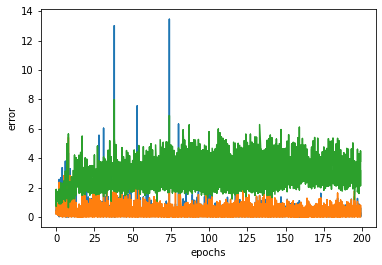

In [ ]:
plt.plot(epochs, d_fake_errs)
plt.plot(epochs, d_real_errs)
plt.plot(epochs, g_errs)
plt.xlabel("epochs")
plt.ylabel("error")

In [ ]:
def raw_to_midi(array, name, precision=0.7):
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)

    array = np.array(list(map(lambda x: 0 if x < precision else 1, array)))
    array = array.reshape((64, 84))
    for time_idx in range(64):
        for pitch_idx in range(84):
            if array[time_idx, pitch_idx] == 1:
                # note = pretty_midi.Note(
                # velocity=100, pitch=25 + pitch_idx, start=1 / 16 * time_idx, end=1 / 16 * (time_idx + 1))
                note = pretty_midi.Note(
                velocity=100, pitch=25 + pitch_idx, start=1 / 8 * time_idx, end=1 / 8 * (time_idx + 1))
                # Add it to our instrument
                piano.notes.append(note)
    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')
    
        



In [ ]:
!mkdir "midi_results"

In [ ]:
root_name = "CNN_"
for x in landmark_seeds_data_list:
  epoch_nb = x[0]
  data = x[1]
  for j in range(len(data)):
    name = root_name + "epoch_" + str(epoch_nb) + "_seed" + str(j)
    raw_to_midi(data[j].reshape(64*84), name, precision=0.9)


In [ ]:
!zip -r /content/resultsCNN2.zip /content/midi_results

updating: content/midi_results/ (stored 0%)
  adding: content/midi_results/CNN_epoch_400_seed3.mid (deflated 74%)
  adding: content/midi_results/CNN_epoch_450_seed2.mid (deflated 78%)
  adding: content/midi_results/CNN_epoch_500_seed2.mid (deflated 73%)
  adding: content/midi_results/CNN_epoch_150_seed3.mid (deflated 79%)
  adding: content/midi_results/CNN_epoch_200_seed1.mid (deflated 62%)
  adding: content/midi_results/test_new_fn.mid (deflated 70%)
  adding: content/midi_results/CNN_epoch_350_seed2.mid (deflated 74%)
  adding: content/midi_results/CNN_epoch_350_seed3.mid (deflated 74%)
  adding: content/midi_results/CNN_epoch_450_seed1.mid (deflated 61%)
  adding: content/midi_results/CNN_epoch_850_seed9.mid (deflated 61%)
  adding: content/midi_results/CNN_epoch_600_seed5.mid (deflated 65%)
  adding: content/midi_results/CNN_epoch_150_seed7.mid (deflated 64%)
  adding: content/midi_results/CNN_epoch_650_seed6.mid (deflated 69%)
  adding: content/midi_results/CNN_epoch_850_seed5.mid